# **Algorithmic Trading: German Electricity Market**

In [ ]:
%load_ext autoreload
%autoreload 2

import json
import random

import holidays
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

pd.options.mode.chained_assignment = None
random.seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [659]:
df = pd.read_csv("data_cleaned.csv", index_col=["Date"], parse_dates=True)
df

,wind,solar,load,spread,Year,Month,spread_winsorized_5_pct,spread_winsorized_1_pct,spread_winsorized_05_pct,spread_hampel_1d,spread_hampel_3d,spread_hampel_7d,wind_log,wind_sqrt,wind_boxcox,solar_yeojohnson,Hour,solar_cleaned
Date,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,6084.0,0.0,43915.0,38.40,2020,January,38.40,38.40,38.40,38.40,38.40,38.40,8.713418,78.000000,29.353093,0.000000,0,0.0
2020-01-01 00:15:00,5739.0,0.0,43770.0,-105.93,2020,January,-105.93,-105.93,-105.93,-105.93,-105.93,-105.93,8.655040,75.756188,28.888807,0.000000,0,0.0
2020-01-01 00:30:00,5774.0,0.0,43267.0,-1.48,2020,January,-1.48,-1.48,-1.48,-1.48,-1.48,-1.48,8.661120,75.986841,28.936862,0.000000,0,0.0
2020-01-01 00:45:00,5804.0,0.0,42934.0,3.97,2020,January,3.97,3.97,3.97,3.97,3.97,3.97,8.666303,76.183988,28.977876,0.000000,0,0.0
2020-01-01 01:00:00,5791.0,0.0,42718.0,100.09,2020,January,100.09,100.09,100.09,100.09,100.09,100.09,8.664060,76.098620,28.960123,0.000000,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 22:45:00,29922.0,2.0,41550.0,102.06,2023,December,102.06,102.06,102.06,102.06,102.06,102.06,10.306349,172.979768,44.875823,1.088188,22,0.0
2023-12-31 23:00:00,29546.0,3.0,40733.0,35.24,2023,December,35.24,35.24,35.24,35.24,35.24,35.24,10.293704,171.889499,44.727901,1.369723,23,0.0
2023-12-31 23:15:00,29204.0,3.0,39805.0,78.57,2023,December,78.57,78.57,78.57,78.57,78.57,78.57,10.282061,170.891779,44.592105,1.369723,23,0.0


## **Feature Engineering**

#### **Date & Time Features**

Date and time-based features provide essential context for understanding temporal patterns in energy data. These features capture:

- **Hourly and Daily Variations**: Fractional hours and specific time of the day help reflect intraday patterns, such as energy demand peaking during working hours.

- **Weekly and Seasonal Trends**: Features like weekday, weekend, month, and quarter allow the model to capture cyclical behaviors influenced by social or environmental factors (e.g., lower demand on weekends, higher wind power in winter).

- **Special Events**: Flags for weekends, daytime, and holidays (specific to Germany) help account for anomalies or deviations in typical patterns.

These features create a structured temporal representation, improving the model's ability to learn complex behaviors over time.

In [ ]:
def extract_time_features(df):
    """
    Extracts various time-based features from a DataFrame with a DatetimeIndex,
    including fractional hours for precise cyclical transformations.
    
    Args:
        df (pd.DataFrame): The DataFrame with a DatetimeIndex.

    Returns:
        pd.DataFrame: The updated DataFrame with new time-based features.
    """
    # Extract basic features
    df['Hour'] = df.index.hour
    df['Minute'] = df.index.minute
    df['FractionalHour'] = df['Hour'] + df['Minute'] / 60
    df['Day'] = df.index.day
    df['Weekday'] = df.index.weekday  # 0=Monday, 6=Sunday
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Quarter'] = df.index.quarter
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week.astype(int)

    season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Autumn": 3}
    def get_season(date):
        if date.month in [12, 1, 2]:
            return "Winter"
        elif date.month in [3, 4, 5]:
            return "Spring"
        elif date.month in [6, 7, 8]:
            return "Summer"
        else:
            return "Autumn"
        
    df['Season'] = df.index.map(get_season)
    df['Season'] = df['Season'].map(season_mapping)
    
    # Weekend and daytime flags
    df['IsWeekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
    df['IsDaytime'] = df["solar_cleaned"].apply(lambda x: 1 if x > 0 else 0)    
    
    # Add a holiday flag for Germany
    german_holidays = holidays.Germany()
    df['IsHoliday'] = df.index.to_series().apply(lambda x: 1 if x in german_holidays else 0)
    
    return df

df = extract_time_features(df)

#### **Cyclical Features**

Time-based features like hours, weekdays, or months are inherently cyclical, but representing them with simple numeric values (e.g., 0–23 for hours) fails to reflect their circular nature. To address this, cyclical features use **trigonometric functions** (sine and cosine) to map time onto a circle, ensuring that values near the boundary (e.g., hour 23 and hour 0) are considered close together.

In [ ]:
def extract_cyclical_features(df, cycles=['hourly', 'daily', 'weekly', 'monthly', 'quarterly', 'annual'], observations_per_day=96):
    """
    Extracts fundamental cyclical features (n_terms=1) for given cycles.

    Args:
        df (pd.DataFrame): DataFrame with a DatetimeIndex.
        cycles (list of str): Cycles to encode. Supported: 'hourly', 'daily', 'weekly', 'monthly', 'quarterly', 'annual'.
        observations_per_day (int): Data frequency per day (e.g., 96 for 15-min intervals).

    Returns:
        pd.DataFrame: Updated DataFrame with cyclical features.
    """
    t = np.arange(len(df))

    cycle_lengths = {
        'hourly': observations_per_day / 24.0,       # 1 hour cycle
        'daily': observations_per_day,              # 1 day cycle
        'weekly': 7 * observations_per_day,        # 1 week cycle
        'monthly': 30 * observations_per_day,     # Approx. 1 month cycle
        'quarterly': 90 * observations_per_day,  # Approx. 3 months cycle
        'annual': 365 * observations_per_day    # Approx. 1 year cycle
    }

    for cycle in cycles:
        if cycle not in cycle_lengths:
            raise ValueError(f"Unsupported cycle '{cycle}'. Choose from {list(cycle_lengths.keys())}.")

        freq = cycle_lengths[cycle]
        df[f'{cycle.capitalize()}_sin'] = np.sin(2 * np.pi * t / freq)
        df[f'{cycle.capitalize()}_cos'] = np.cos(2 * np.pi * t / freq)

    return df

df = extract_cyclical_features(df)

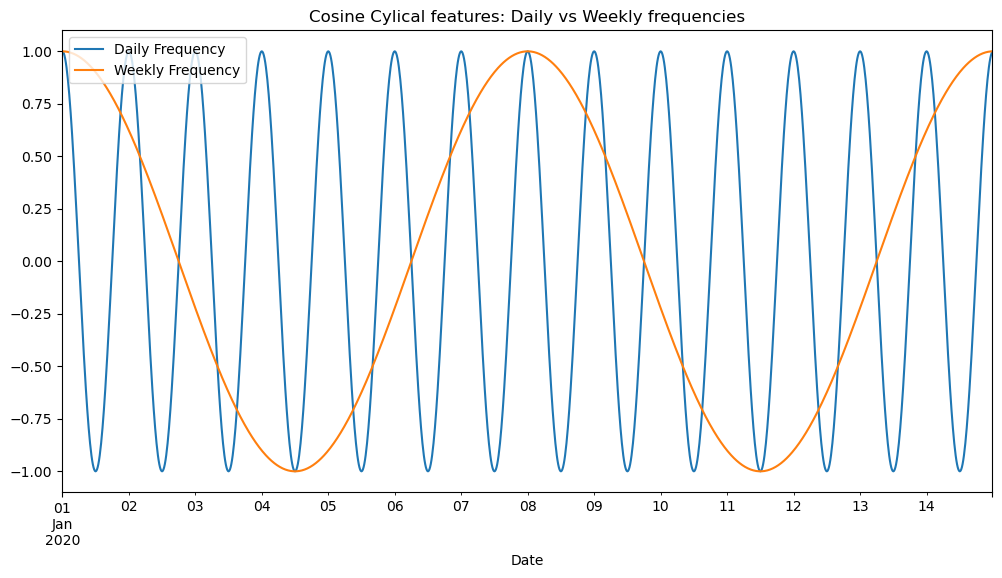

In [175]:
df.loc["2020-01-01": "2020-01-14", "Daily_cos"].plot(figsize=(12, 6), label="Daily Frequency")
df.loc["2020-01-01": "2020-01-14", "Weekly_cos"].plot(figsize=(12, 6), label="Weekly Frequency")
plt.title("Cosine Cylical features: Daily vs Weekly frequencies")
plt.legend(loc='upper left')

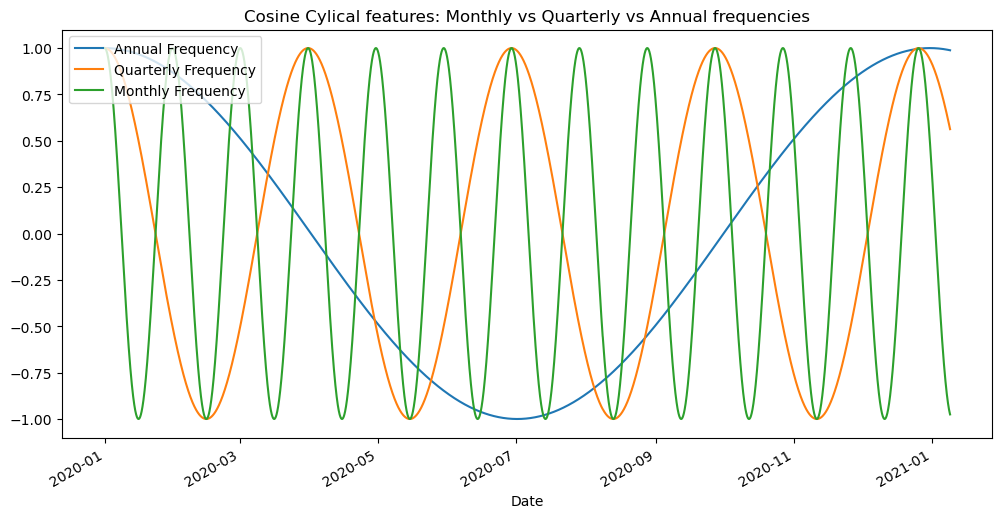

In [176]:
df.loc["2020-01-01":"2021-01-08", "Annual_cos"].plot(figsize=(12, 6), label="Annual Frequency")
df.loc["2020-01-01":"2021-01-08", "Quarterly_cos"].plot(figsize=(12, 6), label="Quarterly Frequency")
df.loc["2020-01-01":"2021-01-08", "Monthly_cos"].plot(figsize=(12, 6), label="Monthly Frequency")
plt.title("Cosine Cylical features: Monthly vs Quarterly vs Annual frequencies")
plt.legend(loc='upper left')

#### **Interaction Effects**

Interaction effects help capture the combined influence of multiple features on the target variable, enabling the model to learn non-linear relationships and dependencies. For example:

- The relationship between wind power and the spread might depend on the level of solar generation or electricity load.
- Combining features like wind and solar power or load and time-based features can highlight synergies or opposing effects.

This method allows the creation of new features using operations such as product, sum, difference, or division, expanding the feature space and providing richer information for predictive modeling.

In [ ]:
def extract_interaction_features(df, interactions, methods=None):
    """
    Extracts specified interaction features from a DataFrame using different techniques.

    Args:
        df (pd.DataFrame): The input DataFrame.
        interactions (list of tuple): List of feature pairs to compute interaction terms.
                                      Each tuple specifies two column names to interact.
        methods (list of str): List of interaction methods to apply. Options:
                               'product', 'sum', 'difference', 'division'. If None, defaults to 'product'.
    
    Returns:
        pd.DataFrame: The updated DataFrame with new interaction features.
    """
    if not isinstance(interactions, list) or not all(isinstance(pair, tuple) for pair in interactions):
        raise ValueError("Interactions must be a list of tuples (e.g., [('Feature1', 'Feature2')]).")
    
    if methods is None:
        methods = ['product']  # Default to product interaction
    
    valid_methods = {'product', 'sum', 'difference', 'division'}
    if not all(method in valid_methods for method in methods):
        raise ValueError(f"Invalid methods provided. Valid methods are: {valid_methods}")
    
    for feature1, feature2 in interactions:
        if feature1 in df.columns and feature2 in df.columns:
            for method in methods:
                if method == 'product':
                    interaction_name = f"{feature1} * {feature2}"
                    df[interaction_name] = df[feature1] * df[feature2]
                elif method == 'sum':
                    interaction_name = f"{feature1} + {feature2}"
                    df[interaction_name] = df[feature1] + df[feature2]
                elif method == 'difference':
                    interaction_name = f"{feature1} - {feature2}"
                    df[interaction_name] = df[feature1] - df[feature2]
                elif method == 'division':
                    interaction_name = f"{feature1} / {feature2}"
                    df[interaction_name] = df[feature1] / (df[feature2] + 1e-6)  # Avoid division by zero
        else:
            raise ValueError(f"Features {feature1} and/or {feature2} not found in DataFrame.")
    
    return df

interactions = [("wind_boxcox", "solar_cleaned"), ("load", "solar_cleaned"), ("load", "wind_boxcox")]
df = extract_interaction_features(df, interactions, methods=["product"]*2) 
df = extract_interaction_features(df, interactions, methods=["sum"]*2) 
df = extract_interaction_features(df, interactions, methods=["difference"]*2)
df = extract_interaction_features(df, interactions, methods=["division"]*2) 

#### **Rolling Features**

Rolling features capture the temporal dynamics and trends in time series data by aggregating values over a defined window. They **smooth short-term fluctuations** and highlight medium- to long-term patterns. For example:

- A rolling mean for wind power over a daily window can capture general trends, filtering out noise from short-term variations.

- A rolling standard deviation for solar power over a weekly window can highlight periods of high or low volatility in generation.

These features are especially useful for identifying **patterns** and **trends** in cyclical or seasonal data, enriching the feature space and allowing the model to better capture time-dependent relationships.

In [ ]:
def extract_rolling_features(df, features, windows=['3h','6h','1d','7d'], observations_per_day=96):
    """
    Extracts rolling mean and standard deviation features for specified windows.

    Args:
        df (pd.DataFrame): The input DataFrame.
        features (list of str): List of feature column names to compute rolling statistics for.
        windows (list of str): List of rolling windows. Supported: '3h', '6h', '1d', '7d', etc.
                               Format: 'Xh' (hours), 'Xd' (days).
        observations_per_day (int): Number of observations per day (e.g., 96 for 15-min intervals).

    Returns:
        pd.DataFrame: Updated DataFrame with rolling mean and std features.
    """
    # Map window durations to number of intervals
    window_lengths = {}
    for window in windows:
        if 'h' in window:
            hours = int(window.replace('h', ''))
            window_lengths[window] = int(hours * observations_per_day / 24)
        elif 'd' in window:
            days = int(window.replace('d', ''))
            window_lengths[window] = int(days * observations_per_day)
        else:
            raise ValueError(f"Unsupported window format '{window}'. Use 'Xh' (hours) or 'Xd' (days).")

    # Calculate rolling mean and std for each feature and window
    for feature in features:
        if feature not in df.columns:
            raise ValueError(f"Feature '{feature}' not found in DataFrame.")
        for window, length in window_lengths.items():
            df[f'{feature}_rolling_mean_{window}'] = df[feature].rolling(window=length).mean()
            df[f'{feature}_rolling_std_{window}'] = df[feature].rolling(window=length).std()

    return df

df = extract_rolling_features(df, ["wind_boxcox", "solar_cleaned", "load"])

### **Data Splitting: Training, Validation and Test sets**

Given the distinct low-volatility regime before 2022 and the high-volatility regime afterward, it would be inappropriate to train the model exclusively on pre-2022 data and evaluate it on post-2022 data. Additionally, since the final predictions will cover the first three quarters of 2024 (9 months), it is logical to align the validation and test periods with this timeframe.

Therefore, an out-of-sample evaluation strategy is adopted, with the training period spanning from 2020 to the end of 2022. The first six months of 2023 are reserved for validation, and the last six months of 2023 serve as the test set.

In [ ]:
target = ["spread_winsorized_5_pct"]

end_train = "2022-12"
start_val = "2023-01"
end_val = "2023-05"
start_test = "2023-06"

train = df.loc[:"2022-12"]
val = df.loc["2023-01":"2023-05"]
test = df.loc["2023-06":]

## **Features Selection**

In this study, we leverage a range of feature selection methods, progressing from simple to advanced techniques. Since the models employed are ensemble-based tree methods, the feature selection process described below is specifically tailored to them.

### **Correlation Filter: Remove redundant features**

This method is useful for eliminating redundant features that are highly correlated with each other or assessing linear relationships with the target variable. In our case, since the relationships between regressors and the target variable are expected to be non-linear, we will primarily use this filter to remove redundant features with pairwise correlations exceeding **80%**.

In [46]:
def correlation_filter(df, threshold=0.8, figsize=(10, 6), annot=True, xtick_rotation=45):
    """
    Removes highly correlated features from a DataFrame and visualizes the correlation heatmap.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the feature set.
    - threshold (float): Correlation threshold above which features are considered highly correlated.
    - figsize (tuple): Size of the heatmap figure.
    - annot (bool): Whether to annotate the heatmap with correlation values.
    - xtick_rotation (int): Rotation angle for x-axis tick labels.

    Returns:
    - List: A list of features that are identified as redundant.
    """
    corr_matrix = df.corr().abs()

    # Create the upper triangular matrix to identify redundant features
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1)
    upper_corr_matrix = pd.DataFrame(upper_triangle * corr_matrix, 
                                     index=corr_matrix.index, 
                                     columns=corr_matrix.columns)

    redundent_features = [column for column in upper_corr_matrix.columns if any(upper_corr_matrix[column] > threshold)]

    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=annot, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.xticks(rotation=xtick_rotation)  # Rotate x-axis labels
    plt.yticks(rotation=0)  # Keep y-axis labels horizontal for clarity
    plt.show()
    
    return redundent_features

### **Wrapper Method: Recursive Feature Elimination (RFE)**

Wrapper methods evaluate subsets of features by training a model and assessing its performance. **Recursive Feature Elimination (RFE)** is a widely used wrapper method that iteratively removes the least important features based on the model’s performance, making it particularly effective for reducing dimensionality while retaining the most relevant features.

This method is computationally more expensive than filter methods but generally provides better feature subsets because it considers the predictive power of features in combination.

In [ ]:
def rfe(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rfe = RFE(estimator=model, n_features_to_select=10, step=1)
    rfe.fit(X_train.to_numpy(), y_train.to_numpy().ravel())
    selected_features = X_train.columns[rfe.support_]
    return selected_features

### **Embedded Method: Leverage Model-Driven Feature Selection**

Embedded methods perform feature selection during model training, leveraging the model’s internal mechanisms to rank features by importance. For tree-based models like Random Forest or XGBoost, importance is measured based on how effectively features reduce impurity across splits.

When dealing with large feature sets, **Embedded Method** is often combined with wrapper methods like RFE. In this approach, RFE is applied first to eliminate the least relevant features, and the embedded method is then used to refine the remaining subset, ensuring only the most impactful features are retained.

In [48]:
def embedded_method(X_train, y_train):
    rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)
    rf.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

    feature_importances = rf.feature_importances_
    features = X_train.columns

    importance = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance = importance.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(8, 6))
    plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis() 
    plt.show()

    return importance

### **Expert-based feature selection approach: Correlation Filter + Embedded Method**

This approach constructs the feature set by selecting plausible features and refining them using quantitative feature selection techniques. First, a correlation filter removes highly correlated features to reduce redundancy. Given the relatively small feature set, Recursive Feature Elimination (RFE) is skipped, and an embedded method is directly applied.

In [693]:
features_expert = [
    "wind_boxcox", "load", "solar_cleaned",
    "Daily_cos", "Daily_sin",
    "Weekly_cos", "Weekly_sin", 
    "Monthly_cos", "Monthly_sin",
    "Quarterly_cos", "Quarterly_sin", 
    "DayOfYear"
]

features_expert = ["wind_boxcox", "load", "solar_cleaned",
            "Daily_cos", "Daily_sin", 
            "Weekly_cos", "Weekly_sin", 
            "Monthly_cos", "Monthly_sin",
            "Quarterly_cos", "Quarterly_sin",
            "load / solar_cleaned", "load * solar_cleaned", "Month"]

X_train_expert = train[features_expert]
y_train = train[target]

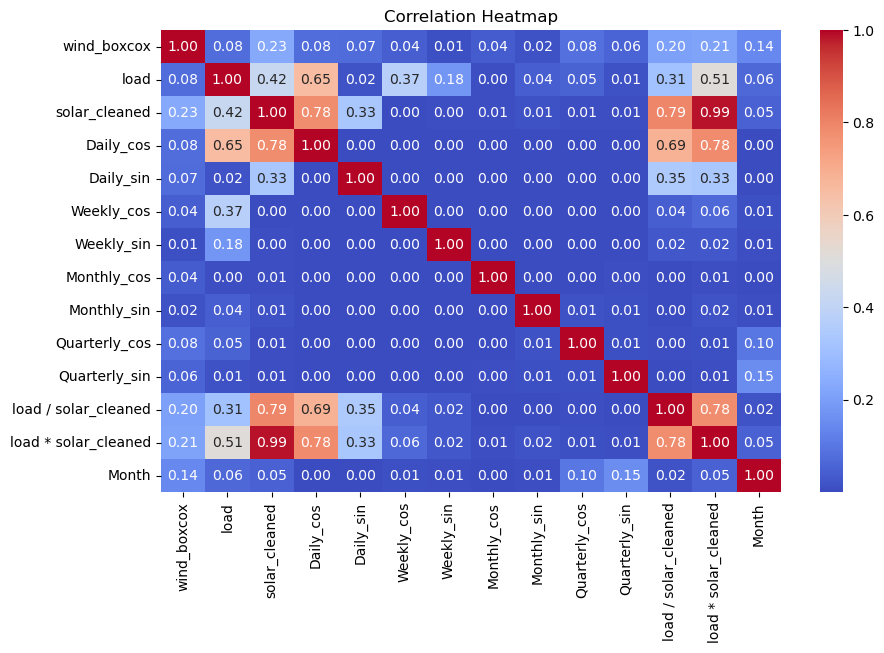

['load * solar_cleaned']

In [694]:
invalid_features_corr = correlation_filter(X_train_expert, threshold=0.8, xtick_rotation=90)
X_train_expert = X_train_expert.drop(columns=invalid_features_corr)
invalid_features_corr

Most of the features show a close to **0** correlation despite a few of them like **Daily_cos vs load** and **solar_cleaned vs Daily_cos** but as they don't meet the correlation threshold we keep them.

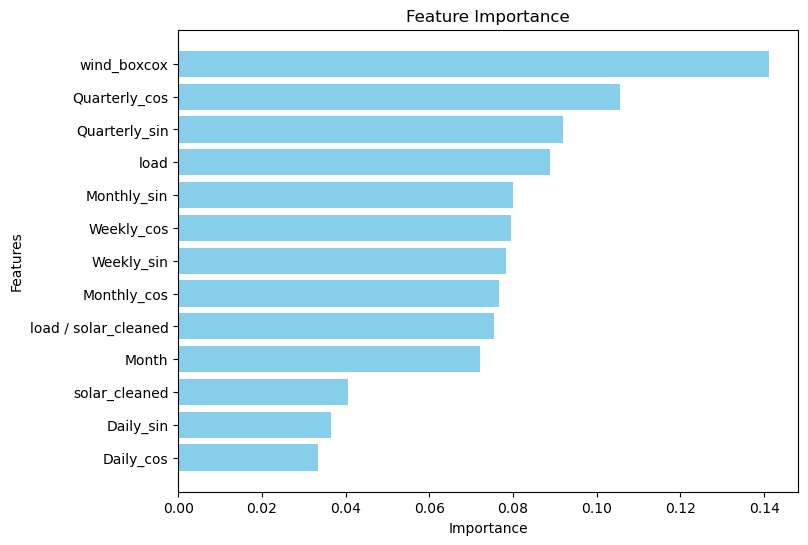

In [695]:
feature_importances = embedded_method(X_train_expert, y_train)

The majority of the regressors demonstrate significant relevance, with `DayOfYear`, `wind_boxcox`, and `Quarterly_cos` emerging as the most impactful features. In contrast, the last three features—solar_cleaned, `Daily_sin`, and `Daily_cos` show much lower importance compared to the others and can be removed to enhance simplicity.

In [696]:
invalid_features_fi = feature_importances["Feature"].to_list()[-3:]
X_train_expert = X_train_expert.drop(columns=invalid_features_fi)

### **Brute-Force Approach: Correlation Filter + Wrapper + Embedded Method**

This approach begins with a large feature set to uncover potentially hidden useful features. To systematically refine the features:

- **Correlation Filter:** Removes highly correlated features to eliminate redundancy.

- **Wrapper Method (RFE):** Reduces the feature set to a manageable size.

- **Embedded Method:** Retains only the most relevant features for the final model.

In [53]:
original_features = ["wind", "wind_sqrt", "wind_log", "solar", "solar_yeojohnson"]
features_bf = [col for col in df.columns if not "spread" in col and not col in original_features]

X_train_bf = train[features_bf].dropna()
y_train_bf = train.loc[X_train_bf.index, target] # Because of rolling window

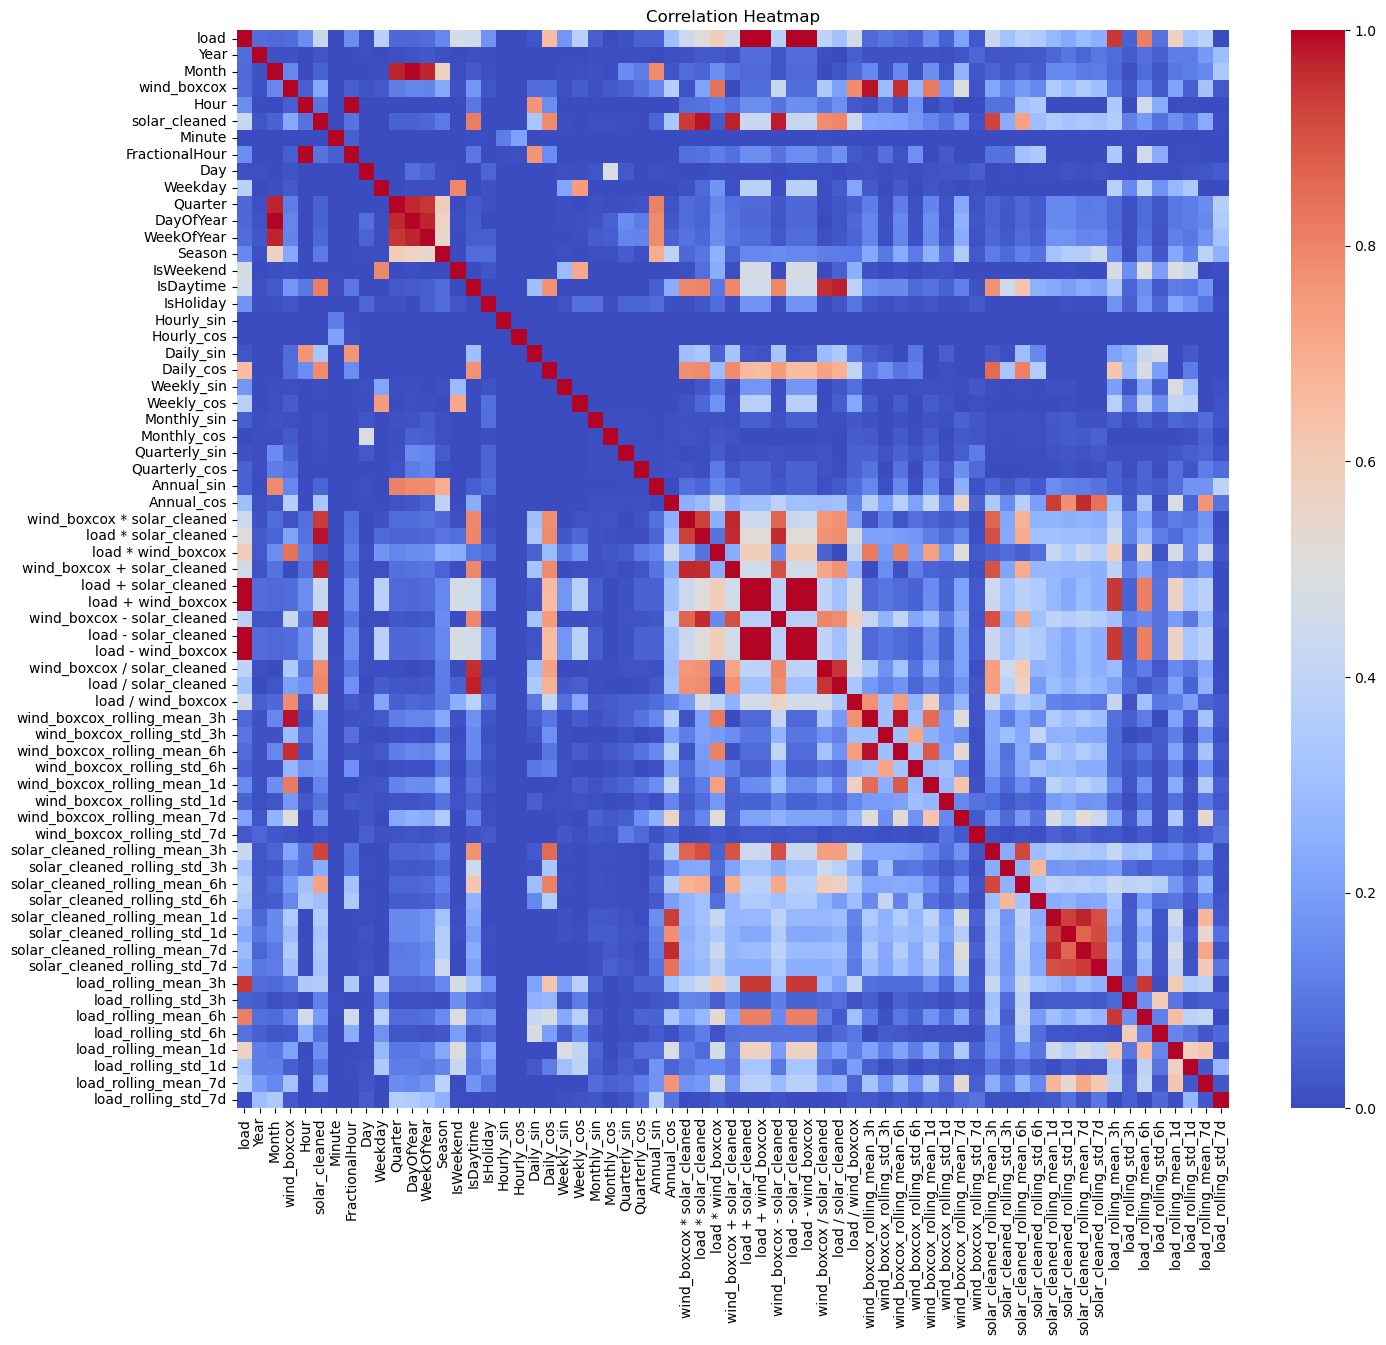

['FractionalHour',
 'Quarter',
 'DayOfYear',
 'WeekOfYear',
 'IsDaytime',
 'Annual_sin',
 'wind_boxcox * solar_cleaned',
 'load * solar_cleaned',
 'load * wind_boxcox',
 'wind_boxcox + solar_cleaned',
 'load + solar_cleaned',
 'load + wind_boxcox',
 'wind_boxcox - solar_cleaned',
 'load - solar_cleaned',
 'load - wind_boxcox',
 'wind_boxcox / solar_cleaned',
 'load / solar_cleaned',
 'wind_boxcox_rolling_mean_3h',
 'wind_boxcox_rolling_mean_6h',
 'wind_boxcox_rolling_mean_1d',
 'solar_cleaned_rolling_mean_3h',
 'solar_cleaned_rolling_mean_6h',
 'solar_cleaned_rolling_mean_1d',
 'solar_cleaned_rolling_std_1d',
 'solar_cleaned_rolling_mean_7d',
 'solar_cleaned_rolling_std_7d',
 'load_rolling_mean_3h',
 'load_rolling_mean_6h']

In [54]:
invalid_features_corr_bf = correlation_filter(X_train_bf, threshold=0.8, annot=False, figsize=(16, 14), xtick_rotation=90)
X_train_bf = X_train_bf.drop(columns=invalid_features_corr_bf)
invalid_features_corr_bf

All interaction effects have been removed due to high correlation with the original features, along with most rolling statistics for solar_cleaned. In contrast, no cyclical features were eliminated.

In [ ]:
valid_features_rfe = rfe(X_train_bf, y_train_bf)
valid_features_rfe

Index(['load', 'wind_boxcox', 'Quarterly_cos', 'Annual_cos',
       'wind_boxcox_rolling_std_1d', 'wind_boxcox_rolling_mean_7d',
       'wind_boxcox_rolling_std_7d', 'load_rolling_std_3h',
       'load_rolling_mean_7d', 'load_rolling_std_7d'],
      dtype='object')

The original features, except `solar_cleaned`, were selected by RFE, while many rolling features for load and wind were retained. Finally, most cyclical features were removed.

In [673]:
valid_features_rfe = pd.Index(['load', 'wind_boxcox', 'Quarterly_cos', 'Annual_cos',
       'wind_boxcox_rolling_std_1d', 'wind_boxcox_rolling_mean_7d',
       'wind_boxcox_rolling_std_7d', 'load_rolling_std_3h',
       'load_rolling_mean_7d', 'load_rolling_std_7d'],
      dtype='object')

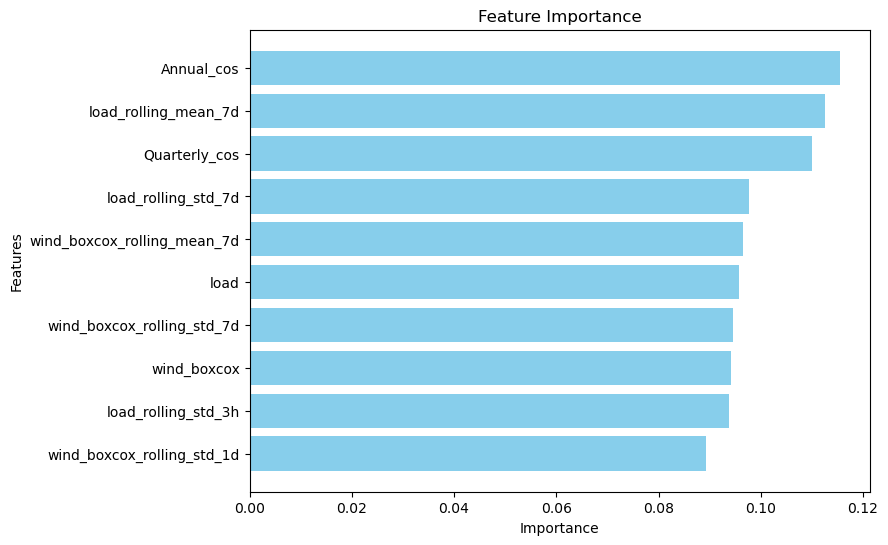

In [674]:
X_train_bf = X_train_bf[valid_features_rfe]
feature_importances_bf = embedded_method(X_train_bf, y_train_bf)

While load and wind_boxcox were the most important features in the expert-based approach, the brute-force method highlights comparable importance for rolling features. Random Forest favors rolling-based features for impurity reduction, while cyclical and time-based features are less relevant.

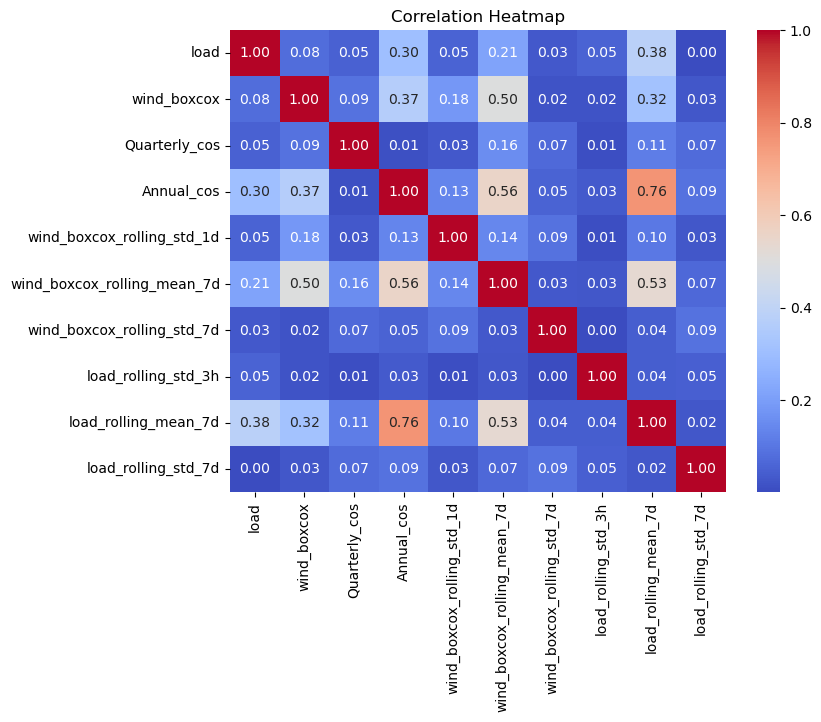

[]

In [675]:
correlation_filter(X_train_bf, figsize=(8, 6), xtick_rotation=90)

As you can see the selected features don't appear to be redundent except `load_rolling_mean_7d` which can be remove.

In [676]:
X_train_bf = X_train_bf.drop(columns="load_rolling_mean_7d")

### **Hybrid Approach: Best of Expert based and Brute force features**

This approach combines the strengths of the previous methods by integrating domain knowledge with promising features identified through the brute-force approach. A correlation filter is first applied to remove redundancy, followed by an embedded method to select the most meaningful features for the final model.

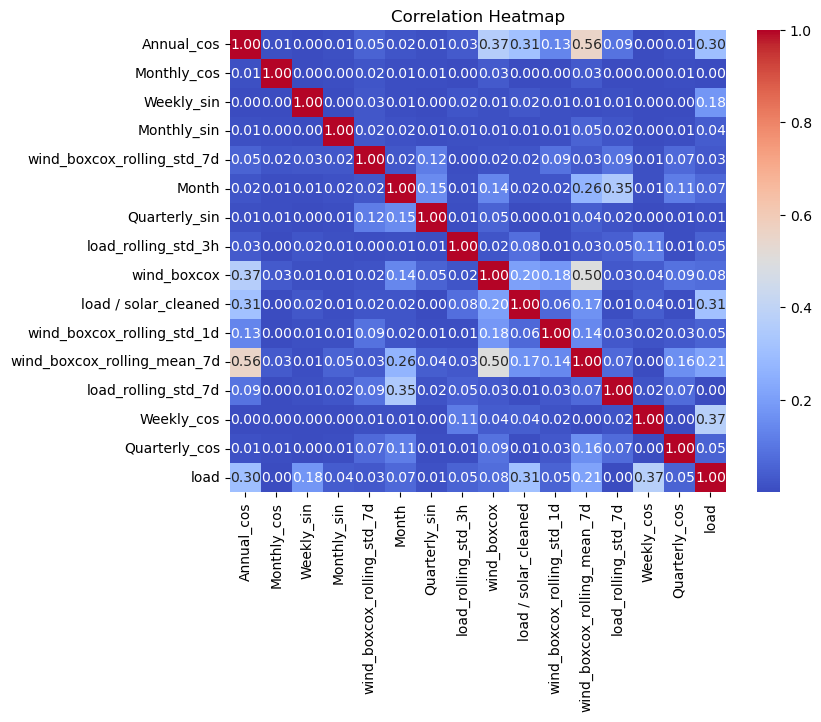

[]

In [698]:
features_hybrid = list(set(X_train_expert.columns.tolist() + X_train_bf.columns.tolist()))
X_train_hybrid = train[features_hybrid].dropna()
y_train_hybrid = train.loc[X_train_hybrid.index, target["target"]]

correlation_filter(X_train_hybrid, figsize=(8, 6), xtick_rotation=90)

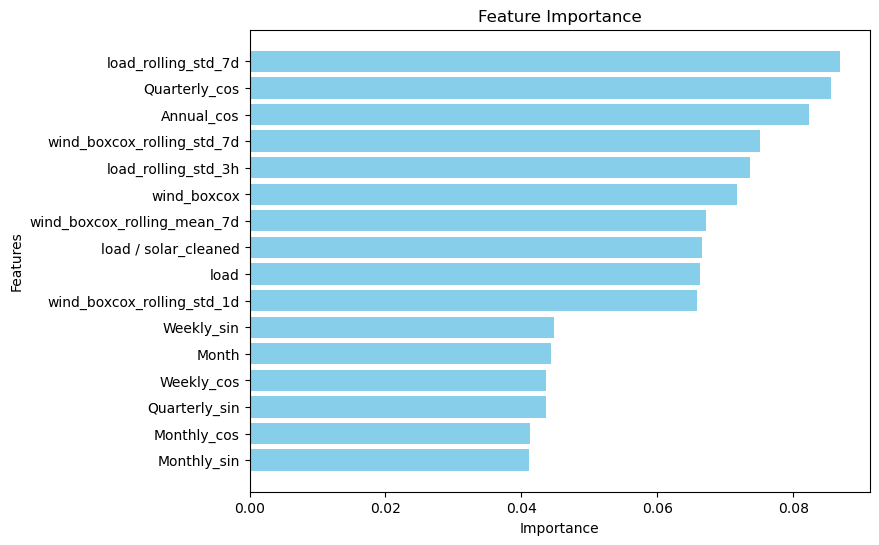

In [699]:
feature_importances_hybrid = embedded_method(X_train_hybrid, y_train_hybrid)

Here we can potentially remove all the features which show a feature importance score less than **5%** however this choice is subjective.

In [704]:
invalid_features_fi_hybrid = feature_importances_hybrid["Feature"].to_list()[-6:]
X_train_hybrid = X_train_hybrid.drop(columns=invalid_features_fi_hybrid)

In [708]:
train.to_csv("train.csv")
val.to_csv("val.csv")
test.to_csv("test.csv")

target = {
    "target": target
}
with open("target.json", "w") as f:
    json.dump(target, f, indent=4)

features = {
    "expert_features": X_train_expert.columns.to_list(),
    "bf_features": X_train_bf.columns.to_list(),
    "hybrid_features": X_train_hybrid.columns.to_list(),
}
with open("features.json", "w") as f:
    json.dump(features, f, indent=4)